# Natural Language Processing: An Application in Public Policy

## by Ancil Crayton

The purpose of this notebook is to guide readers through the process of analyzing the FOMC statements, estimating topic models (i.e. extracting topics), tools for model selection, and calculating measures of negativity and uncertainty within the topic models. This notebook outputs the topic weights and probabilities and proportions of negativite and uncertain language within the statements into a csv file. Those weights and proportions are then used in a regression analysis.

## Part 1: Text Preprocessing

In [1]:
# TRY RUNNING CELL BELOW! If it does not work, create a virtual environment (and respective kernel), 
# uncomment the code below and run to install dependencies
#!pip install -r requirements.txt

In [2]:
!pip install PyPDF

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install pandas

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [4]:
!pip install matplotlib

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [5]:
!pip install seaborn

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [6]:
!pip install scikit-learn

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [7]:
!pip install wordcloud

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [8]:
!pip install gensim
!pip install nltk
!pip install string
!pip install statsmodels

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string
You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [9]:
!pip install pycryptodome
!pip install pdfplumber

You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3 -m pip install --upgrade pip' command.


In [10]:
import sys
print(sys.executable)

/Users/chloelocious/Documents/GitHub/nlp_public_policy/env/bin/python3


In [11]:
# Standard libraries for data frames, arrays, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import seaborn as sns
sns.set(style="white")
%matplotlib inline

# Import Scikit Learn for preprocessing tools and algorithms
import sklearn

# Import library for setting dates
import datetime as dt

# Import library for reading pdf files
import PyPDF2

import pdfplumber

# Import wordclouds for visualizing topics
import wordcloud

# Import gensim library for calculating coherence measures
import gensim

# Import natural language package to remove stopwords and lemmatize terms
import nltk

# Import digits module to filter out numbers
#import re
import string

# Import statsmodels for statistical analysis
import statsmodels

In [12]:
import os
from PyPDF2 import PdfReader  # Import the new PdfReader class

# Function to extract text from a single PDF file
def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

# Directory containing PDF files
pdf_dir = '/Users/chloelocious/Documents/GitHub/nlp_public_policy/ai_policy_data'
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]

# Initialize list to hold statements
statements = []

# Loop through PDF files and extract text
for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_dir, pdf_file)
    pdf_text = extract_text_from_pdf(pdf_path)
    statements.append(pdf_text)

In [13]:
for i in range(min(10, len(statements))):
    print(f"Statement {i+1}:\n{statements[i][:500]}\n")  # Display first 500 characters of each statement

Statement 1:
National Artificial Intelligence
Advisory Committee (NAIAC)
Year l
L
MAY2023_J
1TABLE OF CONTENTS
I. Preface
A. Letter from the Chair & Vice Chair
B. Executive Summary
C. Introduction
D. Acknowledgements
II. NAIAC Year 1 Report
A. Themes, Objectives, & Actions
B. Year 1 Report Appendix
III. Addenda
A. Committee Member Perspectives
B. Committee Member Biographies
C. Committee Overview
D. Working Groups
E. Briefings, Panels, & Public Comments
2LETTER FROM THE CHAIR & VICE CHAIR
Dear Mr. President,

Statement 2:
2019 Progress Report: Federal R&D for Advanced Artificial Intelligence Technologies
SUMMARY OF THE 2019
WHITE HOUSE SUMMIT ON
ARTIFICIAL INTELLIGENCE
IN GOVERNMENT
A Product of
THE WHITE HOUSE
OFFICE OF SCIENCE AND TECHNOLOGY POLICY
SEPTEMBER 9, 2019
0Summary of the 2019 White House Summit on Artificial Intelligence in Government
“Together, we can use the world’s most
innovative technology to make our
government work better for the
American people.”
Michael Kratsios
C

### The text preprocessing steps
Text preprocessing is an important part of the NLP pipeline as it allows us to get more information out of our documents and discard any irrelevant information. The steps you take for preprocessing are dependent on the application, however there are some common steps that are normally taken in many NLP applications.

The preprocessing steps I take here are:
- Lowercasing
- Remove extra spacing
- Remove punctuation
- Removing digits
- Remove stopwords
- Lemmatization

An example of the process for an FOMC statement:

<img src="images/preprocessing.png" alt="FOMC Statement, May 10, 1999" title="Text Preprocessing Example" />

In [14]:
# Import tools to tokenize, remove stopwords, and lemmatize (or stem) words
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords') # download collection of stopwords from NLTK
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
nltk.download('wordnet') # download wordnet dictionary of lemmas
from nltk.stem import WordNetLemmatizer
from string import digits

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chloelocious/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chloelocious/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
# preprocessed_statements = []  # New list to store preprocessed text
# raw_doc_length = []  # List to store lengths of raw documents
# doc_length = []  # List to store lengths of preprocessed documents

# lemmatizer = WordNetLemmatizer()

# for statement in statements:
#     # Calculate raw length
#     tokenize_raw = CountVectorizer().build_tokenizer()(statement)
#     raw_doc_length.append(len(tokenize_raw))

#     # Preprocessing
#     lowercase = statement.lower()
#     tokenize = CountVectorizer().build_tokenizer()(lowercase)
#     remove_digits = [w for w in tokenize if not w.isdigit()]
#     no_stopwords = [w for w in remove_digits if not w in stopwords.words('english')]
#     lemma = [lemmatizer.lemmatize(w) for w in no_stopwords]

#     # Store preprocessed text and its length
#     preprocessed_text = ' '.join(lemma)
#     preprocessed_statements.append(preprocessed_text)
#     doc_length.append(len(lemma))
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Regular expression for URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')

# Custom tokenizer
def custom_tokenizer(text):
    # Lowercase
    text = text.lower()
    # Replace URLs with empty space
    text = url_pattern.sub('', text)
    # Replace newline characters with space
    text = text.replace('\n', ' ')
    # Tokenize by splitting on spaces and remove digits
    tokens = [word for word in text.split() if word.isalpha()]
    return tokens

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

preprocessed_statements = []  # New list to store preprocessed text
raw_doc_length = []  # List to store lengths of raw documents
doc_length = []  # List to store lengths of preprocessed documents

for statement in statements:
    # Custom tokenization
    tokens = custom_tokenizer(statement)
    
    # Calculate raw length
    raw_doc_length.append(len(tokens))

    # Remove stopwords and lemmatize
    no_stopwords = [word for word in tokens if word not in stop_words]
    lemma = [lemmatizer.lemmatize(word) for word in no_stopwords]

    # Store preprocessed text and its length
    preprocessed_text = ' '.join(lemma)
    preprocessed_statements.append(preprocessed_text)
    doc_length.append(len(lemma))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chloelocious/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chloelocious/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
# Example of processed statement
statements[0]

"National Artificial Intelligence\nAdvisory Committee (NAIAC)\nYear l\nL\nMAY2023_J\n1TABLE OF CONTENTS\nI. Preface\nA. Letter from the Chair & Vice Chair\nB. Executive Summary\nC. Introduction\nD. Acknowledgements\nII. NAIAC Year 1 Report\nA. Themes, Objectives, & Actions\nB. Year 1 Report Appendix\nIII. Addenda\nA. Committee Member Perspectives\nB. Committee Member Biographies\nC. Committee Overview\nD. Working Groups\nE. Briefings, Panels, & Public Comments\n2LETTER FROM THE CHAIR & VICE CHAIR\nDear Mr. President,\nThe world has changed dramatically since the National Artificial Intelligence Advisory\nCommittee (NAIAC or the “Committee”) was launched last May. Artificial intelligence (AI)\nnow dominates the public discourse, catalyzing both excitement and concern across the\nglobe. As a result, the relevance of our work as a Committee has increased, and we are\ngrateful for our exceptional fellow Committee members who will ensure NAIAC achieves its\nmission.\nIt is no longer newswor

In [51]:
# Using a sequence number for each document
document_numbers = list(range(1, len(raw_doc_length) + 1))

# Creating a DataFrame for plotting
data_for_plot = pd.DataFrame({
    'Document': document_numbers,
    'Raw': raw_doc_length,
    'Preprocessed': doc_length
})

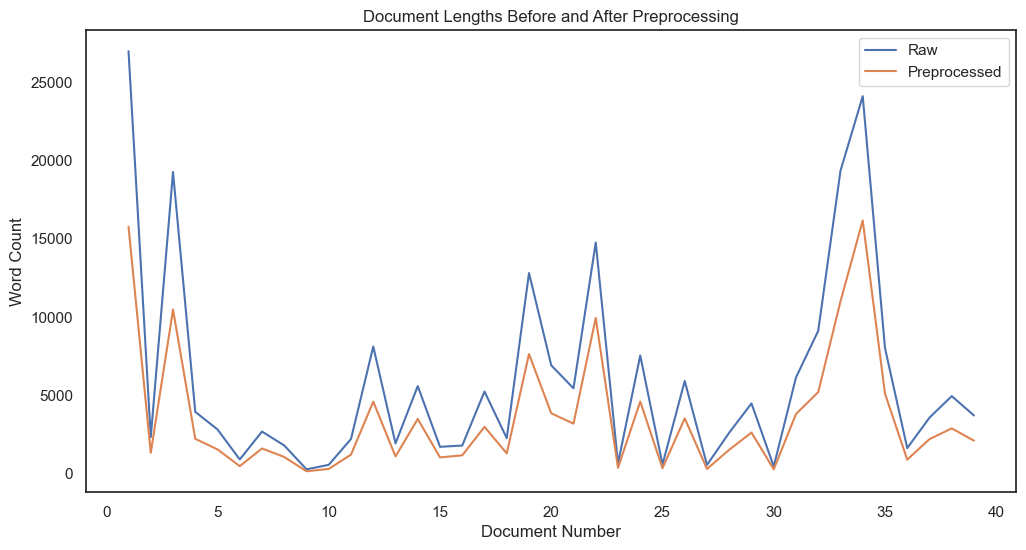

In [52]:
# Plotting the document lengths
plt.figure(figsize=(12, 6))
sns.lineplot(x='Document', y='Raw', data=data_for_plot, label='Raw')
sns.lineplot(x='Document', y='Preprocessed', data=data_for_plot, label='Preprocessed')
plt.xlabel('Document Number')
plt.ylabel('Word Count')
plt.title('Document Lengths Before and After Preprocessing')
plt.legend()
plt.show()

## Part 2: Feature Extraction

Next, we must extract features from the normalized text using the Sci-kit Learn package. We will extract them by transforming the pure text into a weighted document-term matrix. We create unigram and bigram representations. This allows us to look at the frequency of single words and contiguous pairs of words (unigram and bigram, respectively).

Our final weighted matrix is derived from the __Bag of Words Model (BOW)__. BOW is simply a matrix that collects the count of each unique term in the corpus in each document. It has the dimensions (number of documents x number of unique terms).

For a quick example, consider that we have three sentences, each representing a document:
1. I love dogs
2. I hate dogs and knitting
3. knitting is my hobby and my passion

An example of the Bag of Words model would be

<img src="images/bow.jpg" alt="Bag of Words Model" title="BoW model example" />

The Bag of Words model is a useful representation, but it can be improved upon. To make this representation more informative, we apply the term frequency-inverse document frequency weighting scheme to each element of the matrix. The idea behind this is to give the highest priority to words that occur frequently but in a low number of documents.

Term-frequency-inverse document frequency is represented by the following equation

$$ tf-idf = tf(t,d) \text{ x } idf(t, D) $$

where $$idf(t, D) = log(\dfrac{D}{df_{t}})$$

with $tf(t,d)$ and $idf(t,D)$ representing the rewarding term frequency and penalizing document frequency terms, respectively, where $t$ refers to the term and $D$ is the total number of documents.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
# Create unigram TF-IDF weighted matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=0.05, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(statements).toarray()
X_tfidf.shape

(39, 7157)

Although we do not include them in this analysis, you could extend this analysis to include bigrams (word pairs). This can account for words commonly used together such as 'monetary policy', 'financial crisis', 'discount rate', etc.

In [41]:
# Create bigram TF-IDF weighted matrix
#bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.95)
#X1_tfidf = bigram_tfidf_vectorizer.fit_transform(statements).toarray()
#X1_tfidf.shape

## Part 3: Topic Modeling with Non-negative Matrix Factorization

<img src="images/NMF.jpg" alt="Visualization of NMF algorithm" title="Non-negative Matrix Factorization" />

- Developed by Lee and Seung (1999)
- Algorithm learns __parts-based representations__
- __W__ matrix tracks weights of topics in documents
- __H__ matrix tracks weights of unique terms in topics

Minimizes the following objective function:
$$ \dfrac{1}{2}||A - WH||_{F}^{2} = \dfrac{1}{2}\sum_{i=1}^{M}\sum_{j=1}^{N}(A_{ij}-(WH)_{ij})^{2} $$

In [60]:
# # Import NMF from Scikit Learn and 
# from sklearn.decomposition import NMF
# from sklearn import metrics
# Import NMF from Scikit Learn and 
from sklearn.decomposition import NMF
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [61]:
# # Create a function that prints the top words of a topic
# def print_top_words(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic #%d: " % topic_idx
#         message += " ".join([feature_names[i]
#                              for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#     print()
# Regular expression for URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')

def custom_preprocessor(text):
    # Lowercase, remove URLs and newlines
    text = text.lower()
    text = url_pattern.sub('', text)
    text = text.replace('\n', ' ')
    return text

# Initialize TfidfVectorizer with custom preprocessor
tfidf_vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor, stop_words='english')


In [62]:
# # Create a function that prints the topics as a list
# def print_topics(model, feature_names, n_top_words, n_components):
#     topics=list(range(n_components))
#     for topic_idx, topic in enumerate(model.components_):
#         topics[topic_idx]=[str(feature_names[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
#     return topics
# Assuming 'statements' is a list of your documents
X_tfidf = tfidf_vectorizer.fit_transform(statements)
tfidf_feature_names_n1 = tfidf_vectorizer.get_feature_names_out()

In [63]:
# # Assuming tfidf_vectorizer is your TfidfVectorizer object
# tfidf_feature_names_n1 = tfidf_vectorizer.get_feature_names_out()
# Estimate preliminary unigram NMF model with three topics
nmf = NMF(n_components=3, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)

In [64]:
# # Estimate preliminary unigram NMF model with three topics
# nmf = NMF(n_components=3, random_state=1,
#           beta_loss='kullback-leibler', solver='mu', 
#           max_iter=10000).fit(X_tfidf) # minimizes using kullback-leibler with unigrams
# results = print_top_words(nmf, tfidf_feature_names_n1, 15)
# results
# Create a function that prints the top words of a topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# Print top words for each topic
print_top_words(nmf, tfidf_feature_names_n1, 15)

Topic #0: ai government national technology federal agencies american states united intelligence development technologies security dod artificial
Topic #1: ai nsf data research ic systems learning nitrd technology development ml doe machine health explainable
Topic #2: ai data use fms applicant models federal information interview rights facial response human model public



## Part 4: Parameter Selection for Non-negative Matrix Factorization

One of the main issues in topic modelling is deciding on the k parameter. This parameter is the number of topics to estimate in the model. Naturally, when we develop a topic model in the social sciences, we would like our topics to be defined and interpretable. Therefore, to automatically select the k parameter, we use __measures of topic coherence__. In general, topic coherence measures the semantic similarity between the top terms used to represent a topic. There exists numerous measures of coherency with the __most common measures being the $C_{UMass}$, $C_{UCI}$, and $C_{V}$__.

There exists a __distinction between extrinsic and intrinsic topic coherency measures__. Extrinsic measures use __external datasets__ to assess coherency or what we refer to as "background corpora." The argument behind these measures is that using the same dataset to assess coherency would reinforce noise or unusual word statistics. Standard measures for this is the $C_{UCI}$ and the $C_{V}$. Intrinsic measures simply use the main corpus and use empirical estimates of probabilities to define its measure. A standard intrinsic coherence measure is the $C_{UMass}$. All of these measures are openly available in the gensim package.

Since there are no suitable background sources of communication for the FOMC statements, we use $C_{UMass}$ coherency developed by Mimno et al. (2011). Specifically, it measures the ability of a higher weighted word in prediciting a lower weighted word. The equation follows

$$ C_{UMass}(w_i, w_j)^{(t)} = \dfrac{2}{N(N-1)}\sum_{i=2}^{N}\sum_{j=1}^{i-1}log\dfrac{P(w_{i}^{(t)},w_{j}^{(t)}) + \epsilon}{P(w_{j}^{(t)})} $$

In [65]:
# Retrieve modules to set corpous and get coherence. Show logging details to see progress.
from gensim import corpora, models

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'statements' is your list of documents
n = len(statements)

# Tokenize each statement, add terms to dictionary, and build main corpus
for i in range(n):
    tokenizer = CountVectorizer().build_tokenizer()
    statements[i] = tokenizer(statements[i])

dictionary = corpora.Dictionary(statements)
corpus = [dictionary.doc2bow(doc) for doc in statements]

In [68]:
# Parameter selection using intrinsic coherence measure, u_mass. This measure uses the main corpus, which has its issues according to XXX paper
end_k=30
coherencenmf=[]
for k in range(3,end_k+1):
    n_components=k
    nmf = NMF(n_components=n_components, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
    topics=print_topics(nmf, tfidf_feature_names_n1, 15, n_components)
    cm_NMF = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencenmf.append(cm_NMF.get_coherence())
    print('k= %d' % k)
    print_top_words(nmf, tfidf_feature_names_n1, 15)

k= 3
Topic #0: ai government national technology federal agencies american states united intelligence development technologies security dod artificial
Topic #1: ai nsf data research ic systems learning nitrd technology development ml doe machine health explainable
Topic #2: ai data use fms applicant models federal information interview rights facial response human model public

k= 4
Topic #0: ai government national federal intelligence american dod technology artificial development recommendation research department technologies standards
Topic #1: ai nsf ic data research nitrd systems learning ml doe explainable covid machine health program
Topic #2: ai data models fms federal use information regulatory response public agencies model comments explanations risk
Topic #3: shall technology applicant states united use rights ai interview agencies security uas et trade facial

k= 5
Topic #0: ai dod government national recommendation technology intelligence standards department development 

k= 24
Topic #0: inflation longer security term employment agency purchase objective policy pace mortgage maximum run labor month
Topic #1: board approved basis action point discount reserve bank request governor submitted director related taking york
Topic #2: credit purchase security reserve mortgage financial billion condition light overall agency backed housing tool sheet
Topic #3: jr susan roger bies ferguson gramlich vice edward mark olson monetary robert bernanke ben donald
Topic #4: inflation moderate growth likely housing high depend recent fund keep risk incoming quarter time utilization
Topic #5: available demand background weighted generate mainly long weakness may foreseeable future toward economy heightened information
Topic #6: expected fund range condition measure actual gradual labor percent adjustment energy strengthen based realized indicator
Topic #7: recovery level consistent mandate price holding utilization subdued adjust security low review expectation nonresiden

Topic #16: continuing hoenig period thomas resource level longer warranted modest extended stable likely restrain low term
Topic #17: available become unchanged inventory last uncertain currently background information demand prospect goal circumstance strengthening meeting
Topic #18: reduction fomc decline restraint going seems uncertainty forward action current growth recently appears well excess
Topic #19: also purchasing appropriate additional support together continue well longer highly concerned consumer efficacy taken consider
Topic #20: effect increased economy disruption financial act pace condition ass address needed judge information modestly credit
Topic #21: event needed possible increase firming energy respond attainment nevertheless add appears commodity elevated dallas objective
Topic #22: generally monetary fomc reserve firming last employment financial policy longer term expansion interest strength fall
Topic #23: asset current per rather assessment moving add support

k= 29
Topic #0: inflation longer security term agency objective policy labor maximum run pace mortgage employment consistent backed
Topic #1: board approved basis action point discount reserve bank request director submitted governor related taking york
Topic #2: credit purchase security reserve condition mortgage billion financial light backed facility housing anticipate time tool
Topic #3: jr bies ferguson roger susan gramlich vice edward olson mark robert ben bernanke kohn donald
Topic #4: inflation moderate likely growth housing fund high depend recent incoming however utilization risk seems time
Topic #5: available background demand weighted generate foreseeable mainly future long economy heightened growth percent currently information
Topic #6: expected actual fund measure condition labor percent range gradual based strengthen adjustment energy import indicator
Topic #7: level recovery consistent mandate price holding subdued utilization adjust low stable security nonresidential 

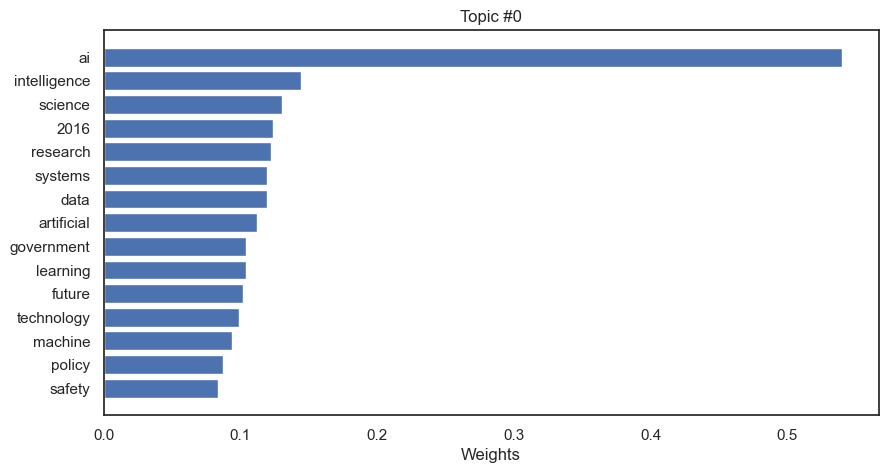

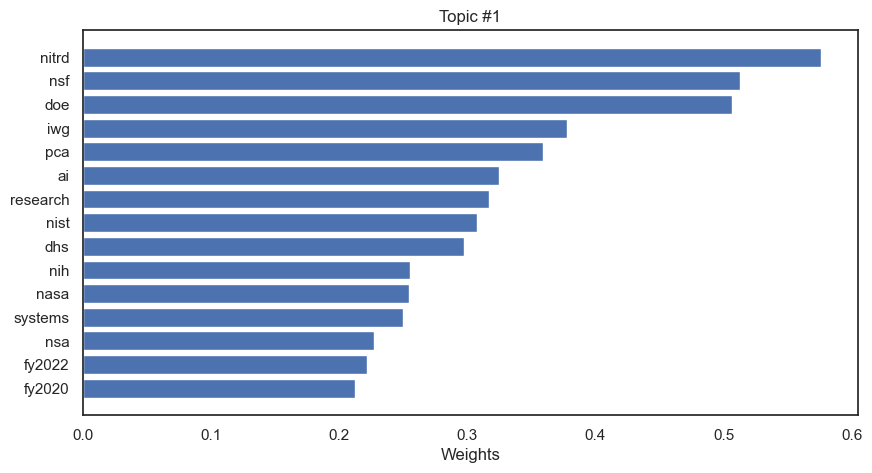

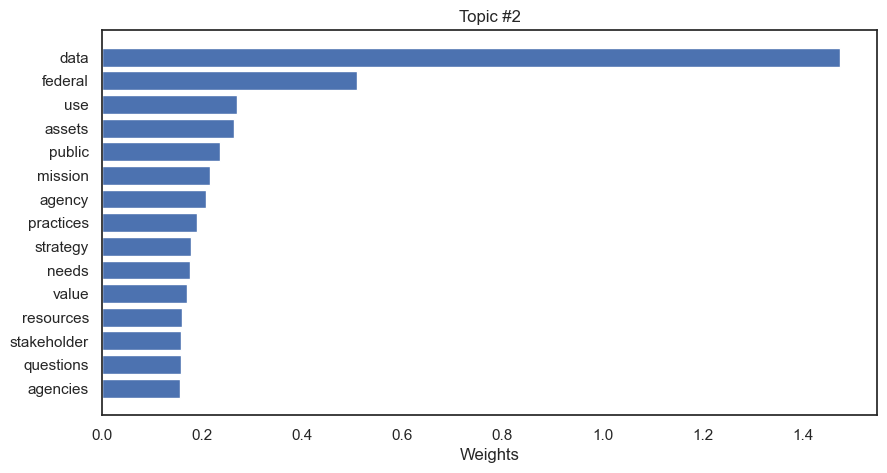

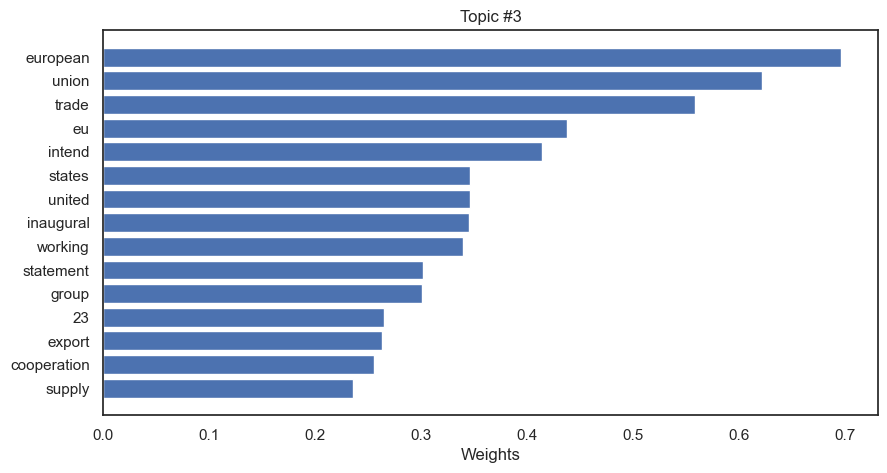

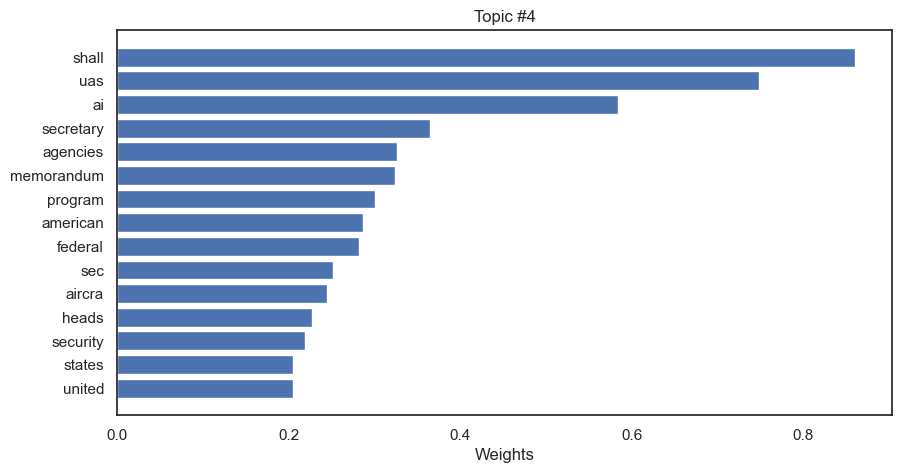

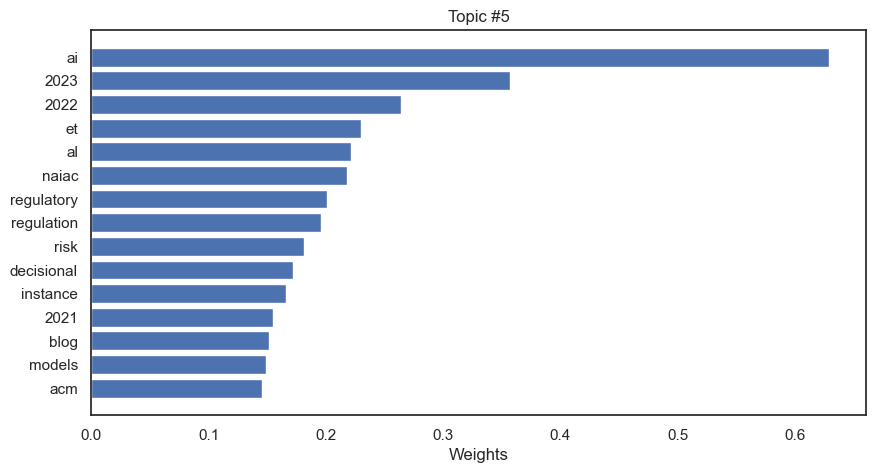

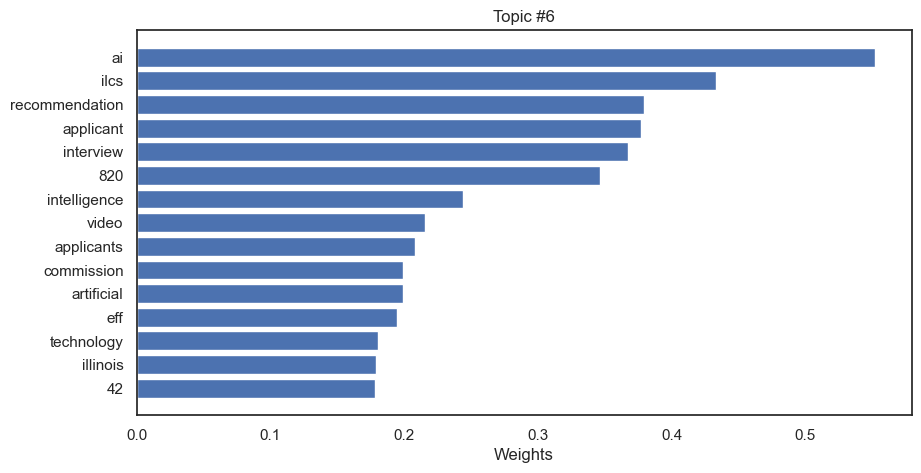

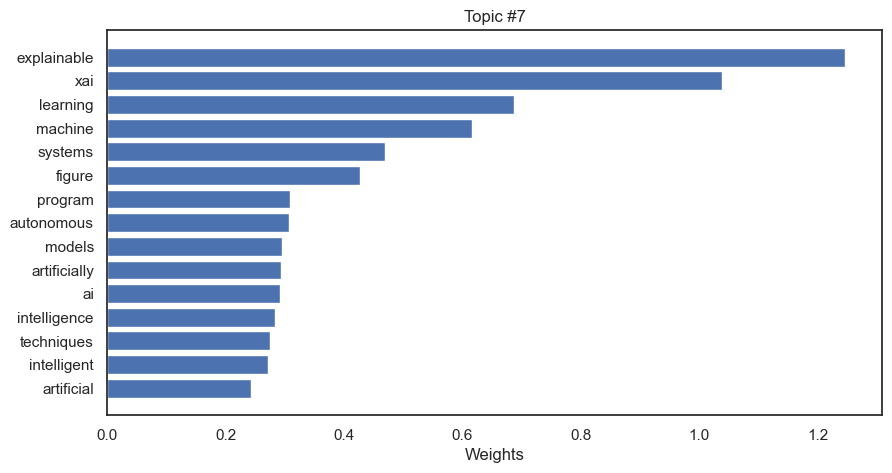

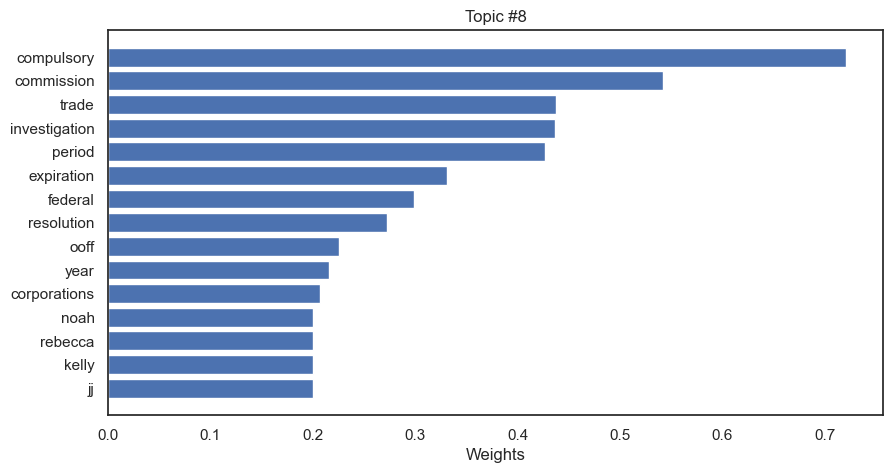

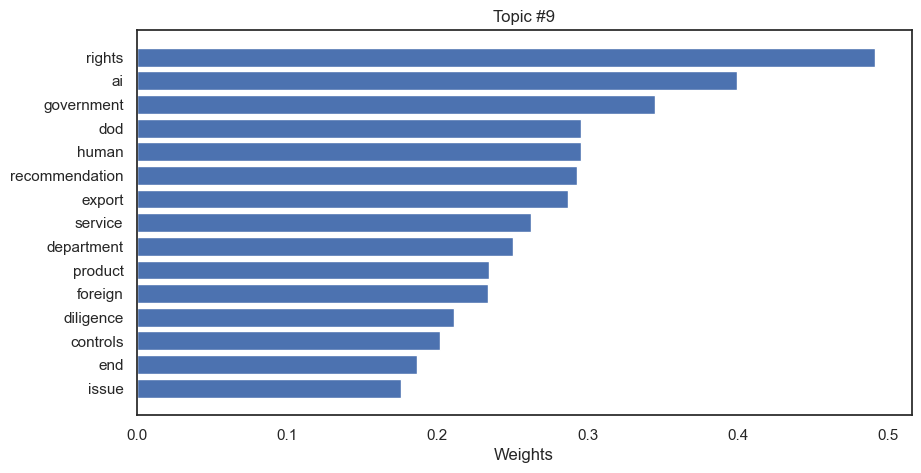

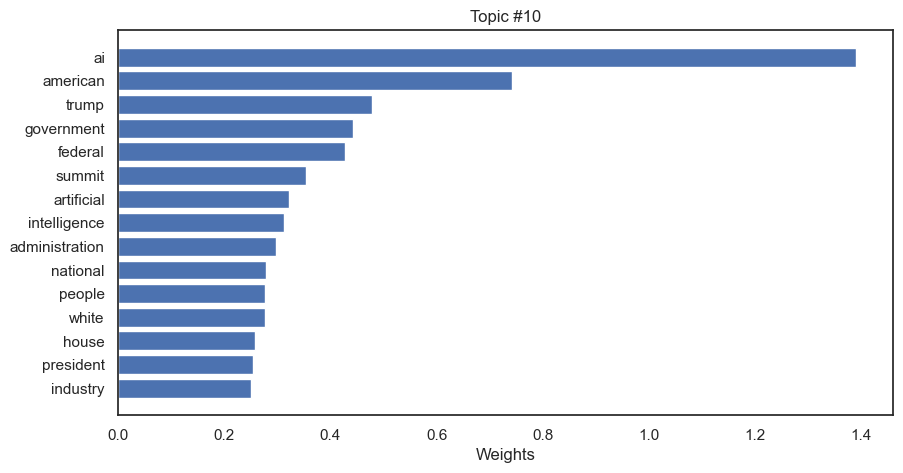

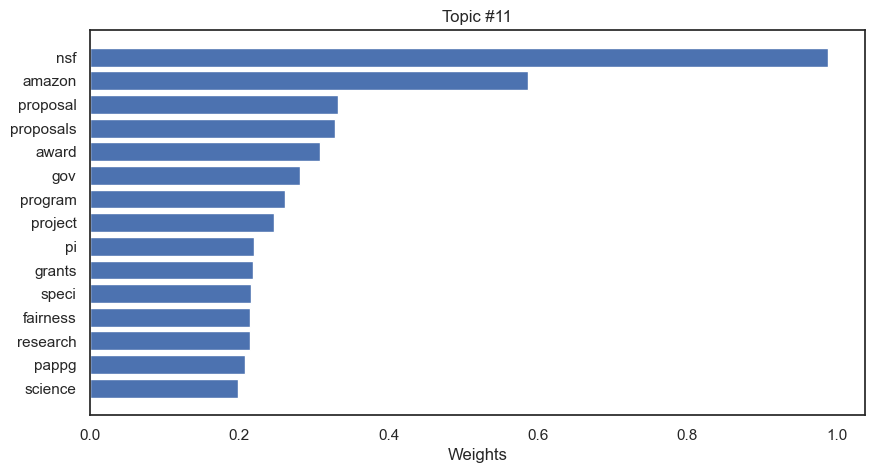

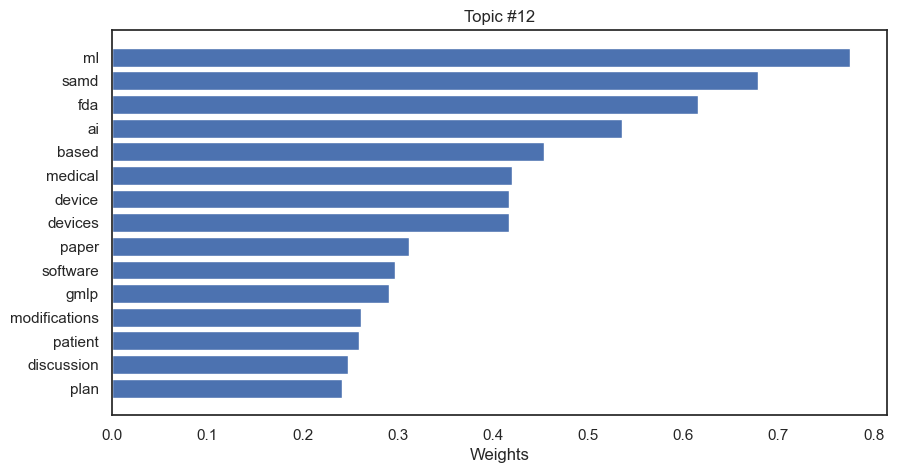

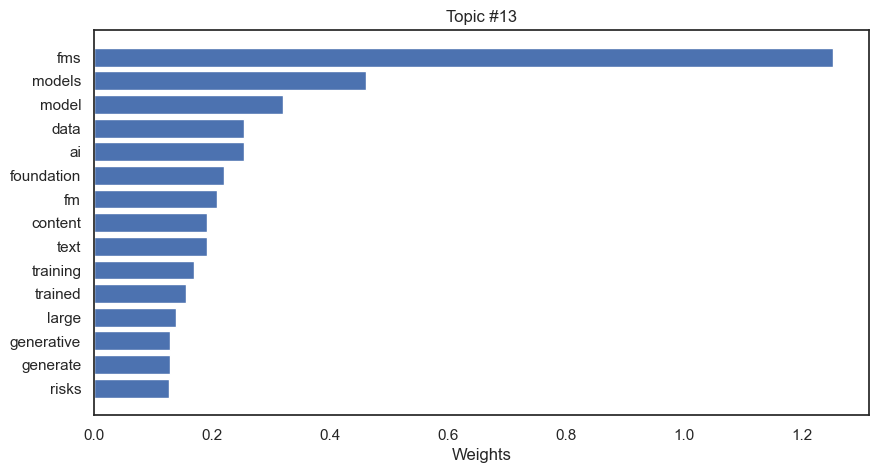

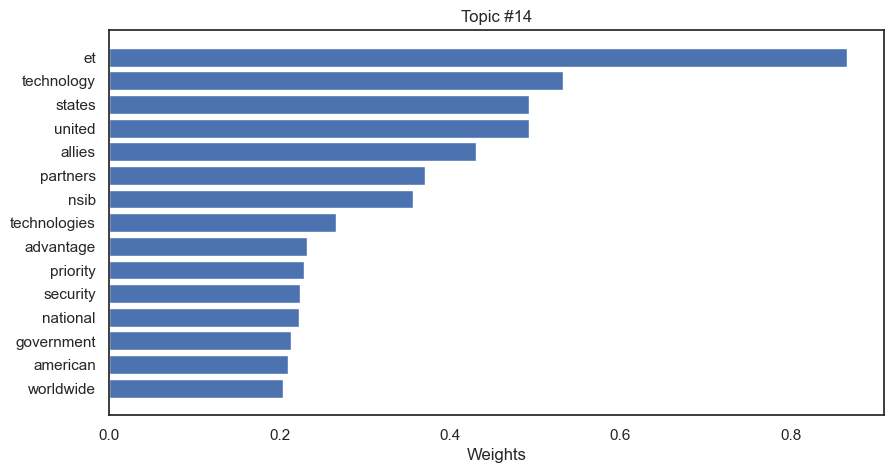

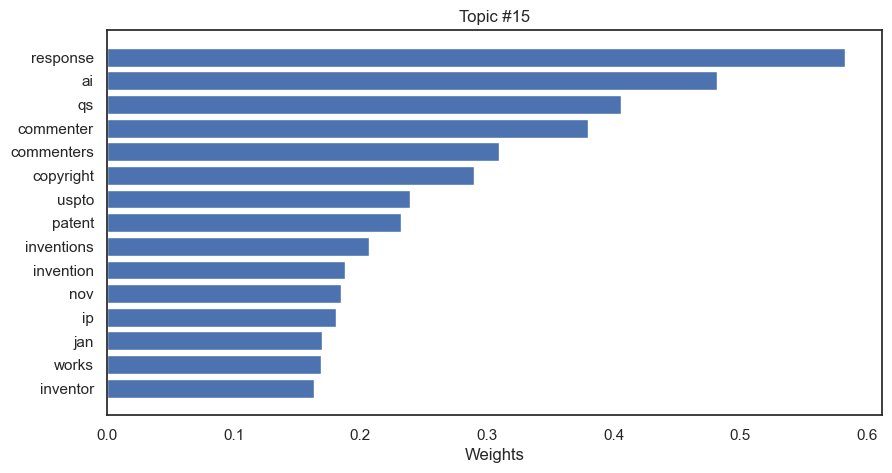

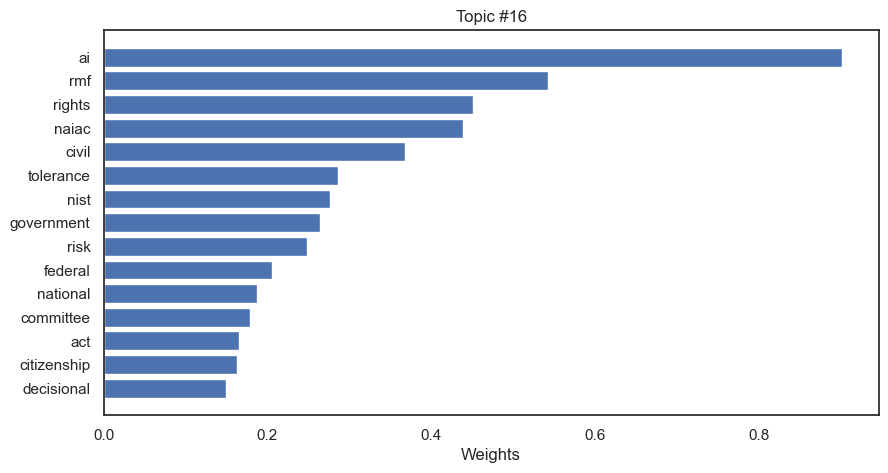

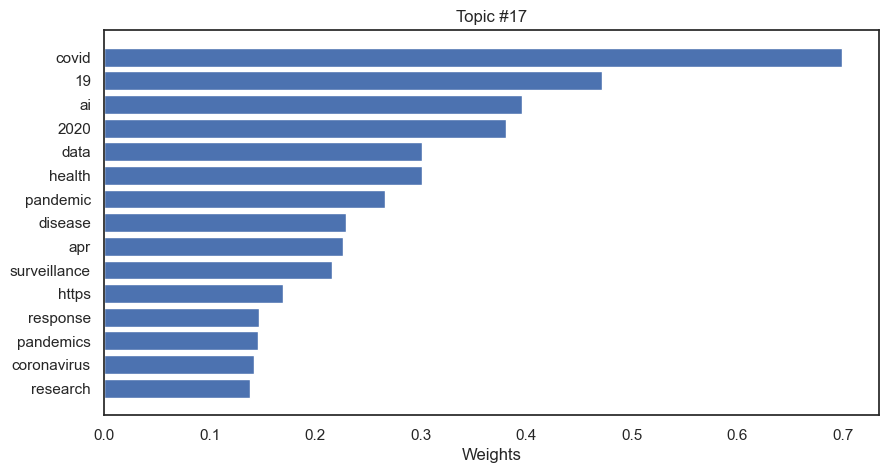

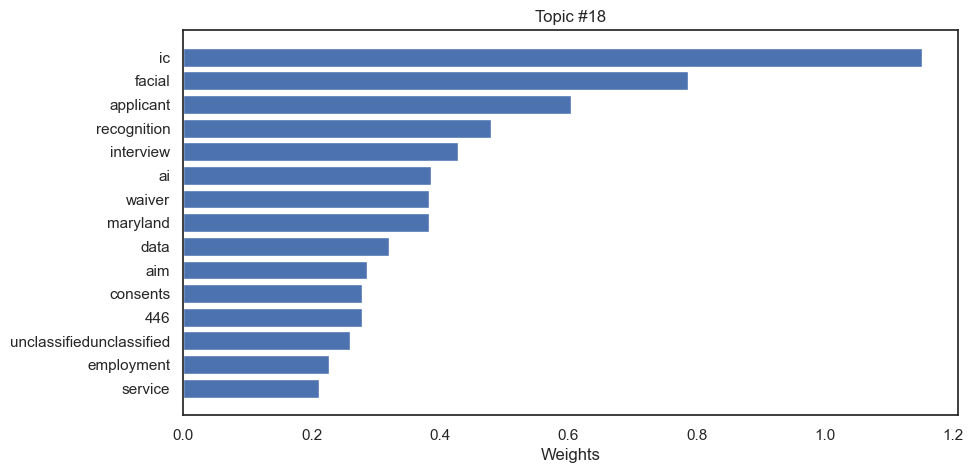

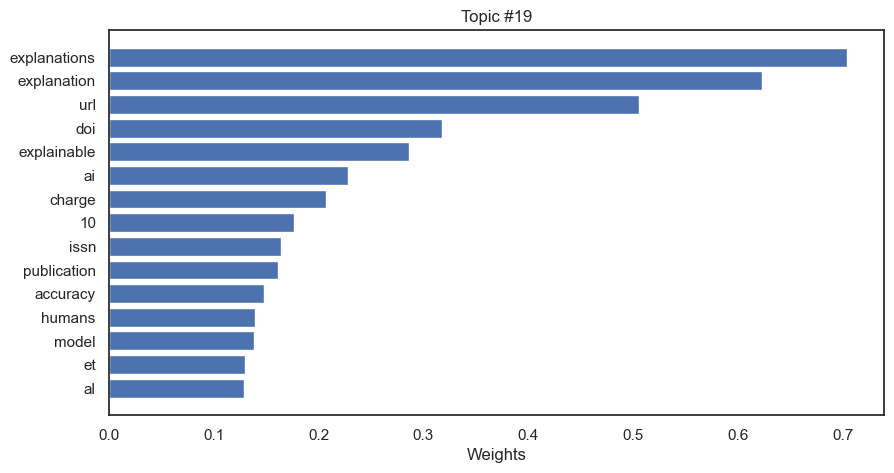

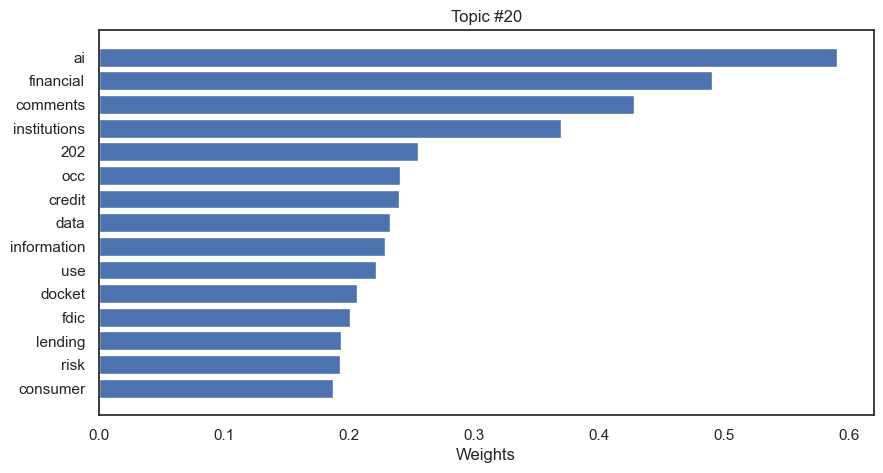

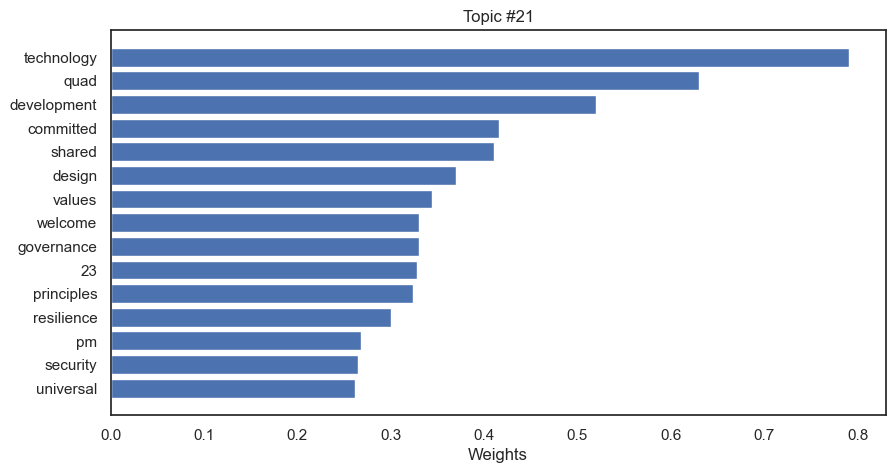

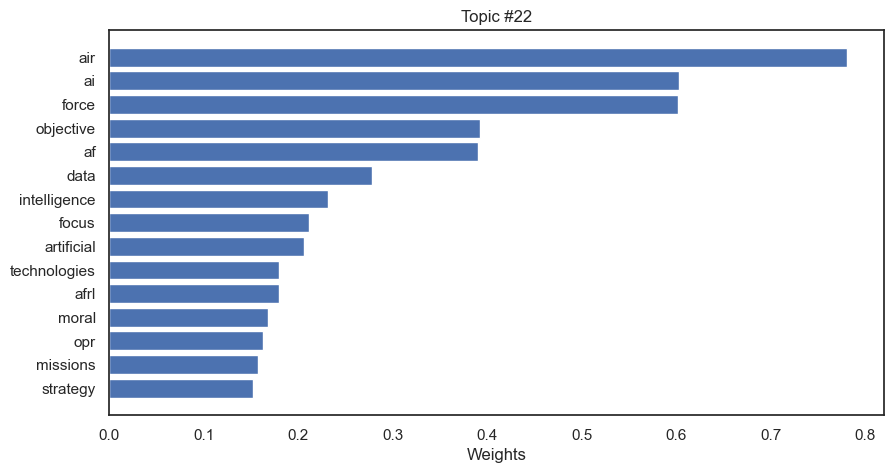

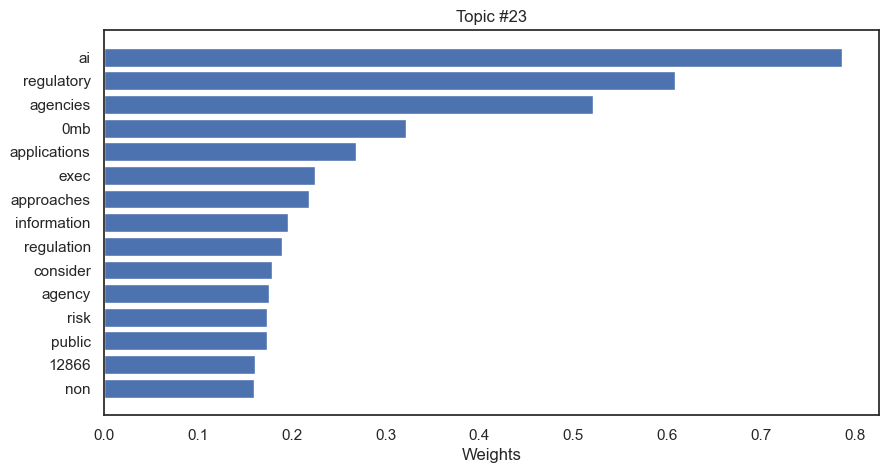

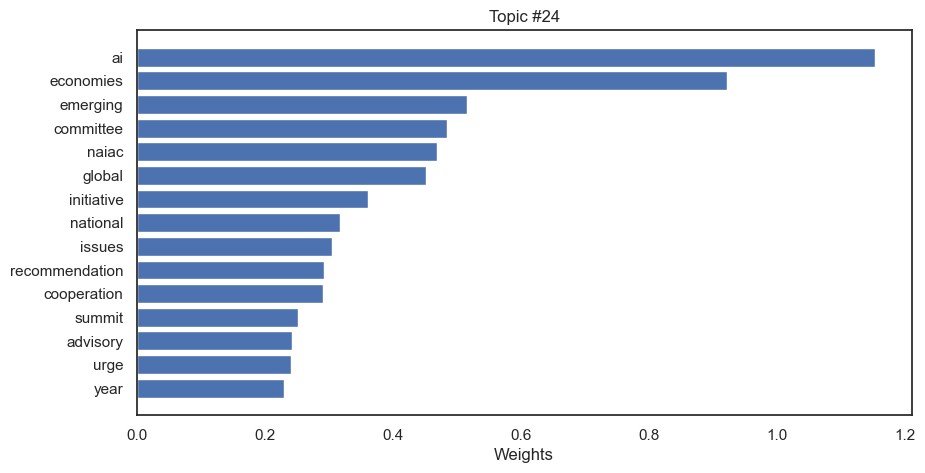

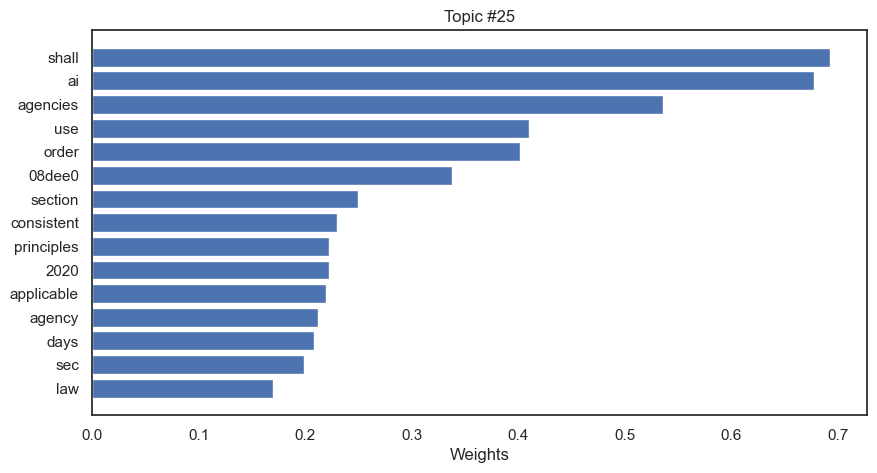

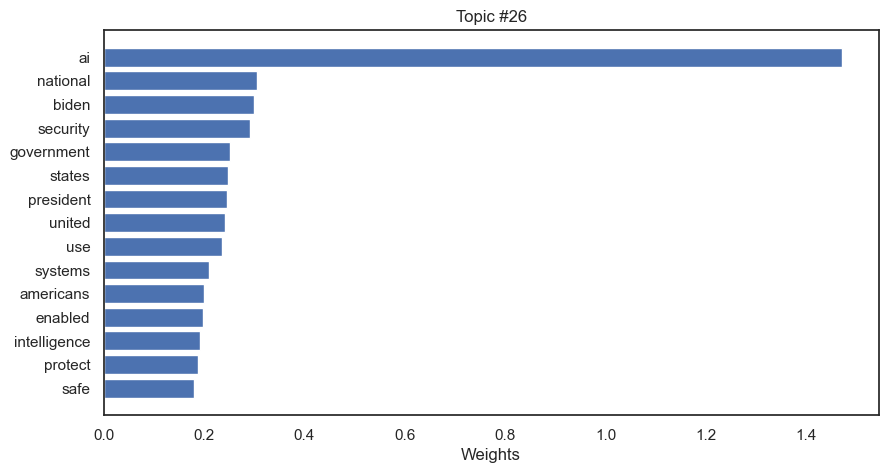

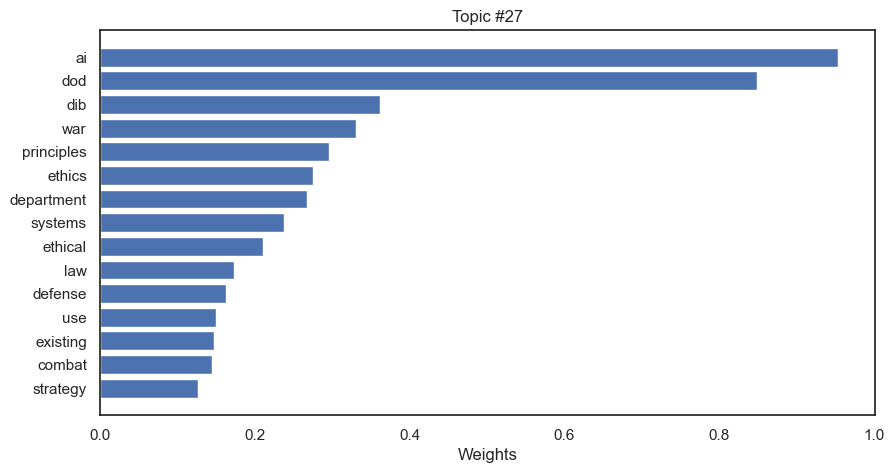

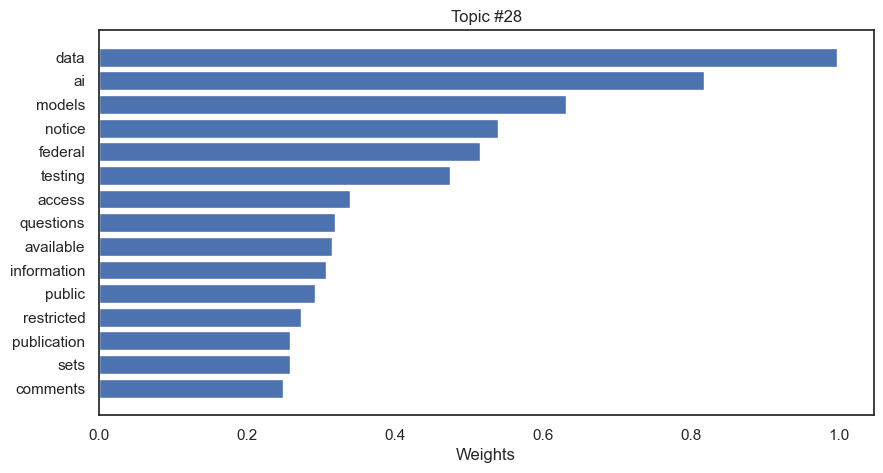

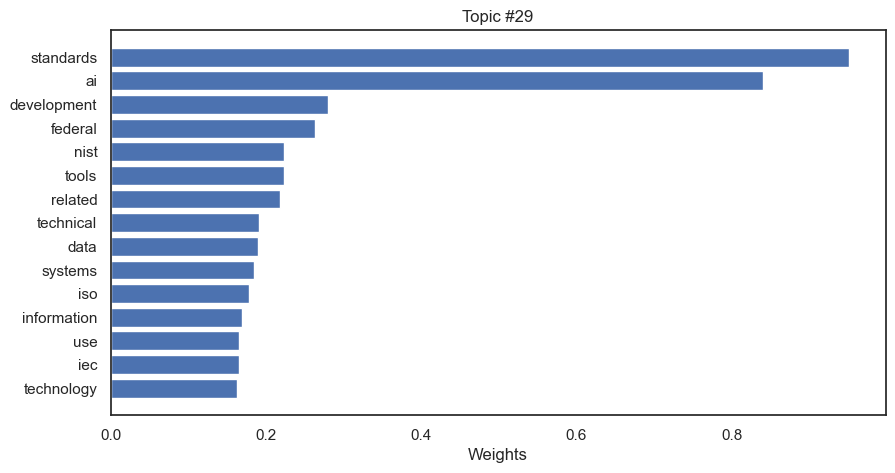

In [84]:
import numpy as np

def plot_top_words(model, feature_names, num_topics, num_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-num_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        plt.figure(figsize=(10, 5))
        plt.barh(range(num_words), weights)
        plt.yticks(range(num_words), top_features)
        plt.xlabel('Weights')
        plt.title(f"Topic #{topic_idx}")
        plt.gca().invert_yaxis()
        plt.show()

plot_top_words(nmf, tfidf_feature_names_n1, 3, 15)


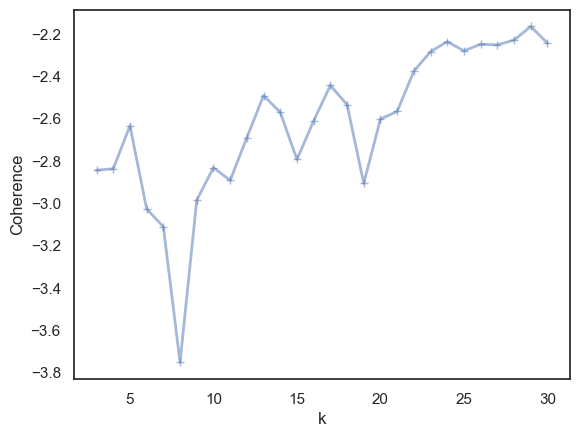

In [69]:
# Plot the coherence over the different 'k' selections
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencenmf, 'b+-', linewidth=2, label='UMass Coherency', alpha=0.5, markevery=1)
ax.set_xlabel('k')
ax.set_ylabel('Coherence')
ax.annotate('Max TC-LCP @ k=3', 
             xy=(3, -0.53001054467878117),  
             xycoords='data',
             xytext=(7, -0.54),
             arrowprops=dict(arrowstyle="simple"))
plt.savefig('images/UMassNMF.png', dpi=300)
plt.show()

Based on the three extrinsic coherency measures using the FOMC minutes as a background corpus, there is a consensus to estimate the model with k=3 as this gives the highest level of coherency. Therefore, we perform NMF with three components below and look to give an interpretation of these topics.

In [70]:
best_nmf = NMF(n_components=3, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
print_top_words(best_nmf, tfidf_feature_names_n1, 15)
best_topics=print_topics(best_nmf, tfidf_feature_names_n1, 15, 3)

Topic #0: ai government national technology federal agencies american states united intelligence development technologies security dod artificial
Topic #1: ai nsf data research ic systems learning nitrd technology development ml doe machine health explainable
Topic #2: ai data use fms applicant models federal information interview rights facial response human model public



I believe that the topic model performed well in the analysis of the FOMC statements as each topic is clearly interpretable. The first topic represents "policy objectives" as it includes descriptors like inflation, security, employment, and price. These are words related to the Federal Reserve's explicit mandates. The second topic is related to "monetary policy tools and targets." Finally, the third topic is related to "financial markets." These are three topics that are useful for further analysis.

In [71]:
# Extract the weights for the model for later regression analysis.
W = best_nmf.fit_transform(X_tfidf) # topic-document weights
H = best_nmf.components_ # word-topic weights

In [72]:
# Dimensions of the W matrix
W.shape

(39, 3)

In [73]:
H.shape

(3, 16537)

## Part 5: Visualization of the NMF Topics

In this section, we plot the topic-document weights as a function of the document dates. This analysis serves the purpose of providing a time series of topic weights to see the intensity of topics over time. This analysis is useful to map historical events back to the output of the topic model as this will provide even more validity to the performance of these models.

In [74]:
# Create dates and NMF weight variables
nmf_theme1_weights = W[:,0]
nmf_theme2_weights = W[:,1]
nmf_theme3_weights = W[:,2]

In [75]:
# A function to plot the weights of the themes
# Create a range for the number of documents
x = range(len(nmf_theme1_weights))
print(x)

def plot_theme_weights(weights, name, color):
    fig, ax = plt.subplots()
    ax.plot(x, weights, '{}-'.format(color), linewidth=2, label='topic 1', alpha=0.6)
    ax.set_ylabel('Weight')
    ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
    ax.axvspan(x[4], x[30], alpha=0.30, color='gray')
    plt.savefig('images/{}.png'.format(name), dpi=300)
    plt.show()

range(0, 39)


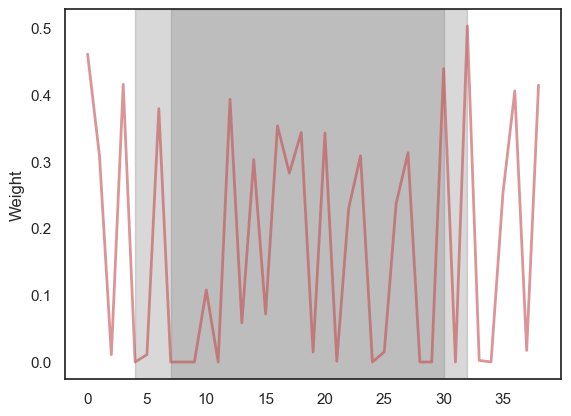

In [76]:
# Plot topic 1 weights as a time series
plot_theme_weights(weights=nmf_theme1_weights, name='NMFWeights1', color='r')

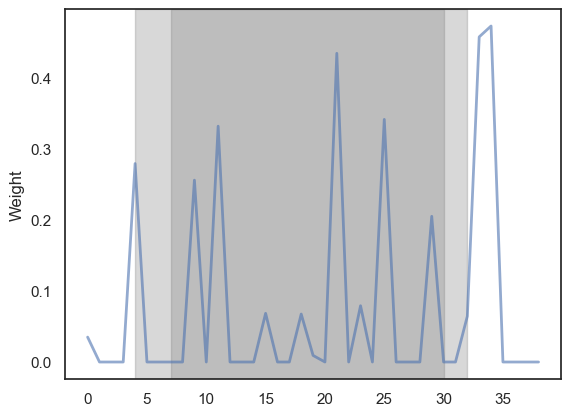

In [77]:
# Plot topic 2 weights as a time series
plot_theme_weights(weights=nmf_theme2_weights, name='NMFWeights2', color='b')

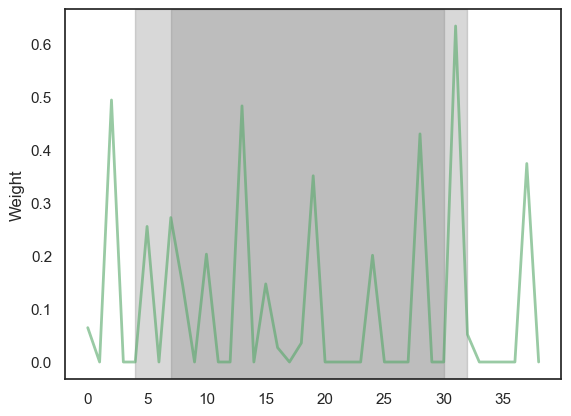

In [78]:
# Plot topic 3 weights as a time series
plot_theme_weights(weights=nmf_theme3_weights, name='NMFWeights3', color='g')

In [ ]:
# Save the weights to a csv file
W = pd.DataFrame(W)
W.to_csv("results/weights.csv")

In this section, I create word clouds for the topics using the wordcloud package. This is good for representing topics in a coherent and clear way. It is also possible to use wordle.net, which is an online, interactive wordcloud creator. It provides more visually appealing wordclouds than the wordcloud package but is not capable of being integrated into Python. It is highly suggested to use that for creating wordclouds to be included in publications.

In [79]:
from wordcloud import WordCloud

In [80]:
def create_wordcloud(words, name):
    topic = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(words))
    plt.figure(figsize=(10, 6))
    plt.imshow(topic, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('images/{}.png'.format(name), dpi=300) # Save figure
    plt.show()

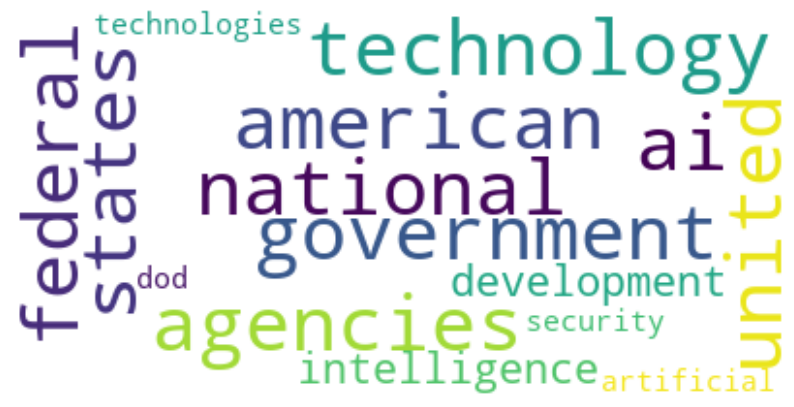

In [81]:
create_wordcloud(words=best_topics[0], name='NMF Theme 1')

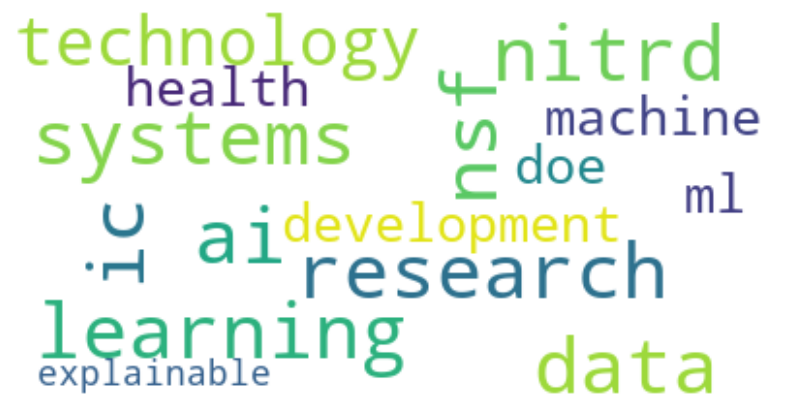

In [82]:
create_wordcloud(words=best_topics[1], name='NMF Theme 2')

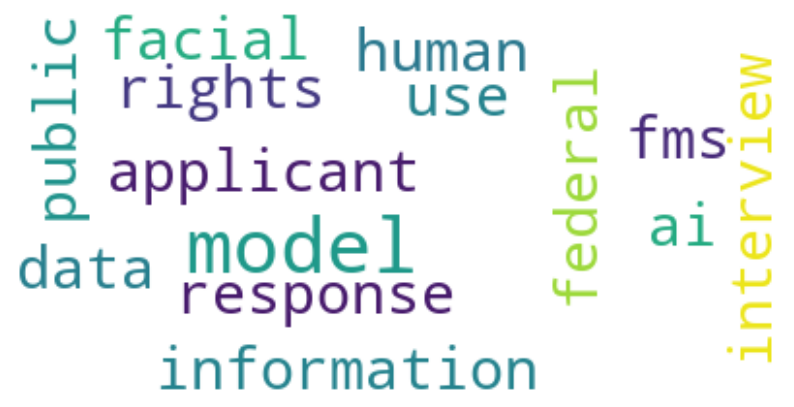

In [83]:
create_wordcloud(words=best_topics[2], name='NMF Theme 3')

## Part 6: Topic Modeling using Latent Dirichelet Allocation

<img src="images/LDA.jpg" alt="Visualization of LDA algorithm" title="Latent Dirichlet Allocation" />

Latent Dirichlet Allocation (LDA) is a probabilistic topic model. What this means is that LDA depends on probabilities to estimate the the parameters of interest. In this model we estimate two key parameters of interest: $\theta_d$ and $\beta_k$.

$\theta_d$ is the analog of the $W$ matrix in NMF and looks at the topic share in the document $d$, while $\beta_k$ is the analog of the $H$ matrix in NMF and estimates the weights of the terms in the topics.

Details about LDA can be found in the original paper by Blei et al. (2003).

In [ ]:
# Import LDA model
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Parameter selection using intrinsic coherence measure, u_mass
coherencelda=[]
end_k = 30
for k in range(3,end_k+1):
    n_components=k
    ldamodel = LatentDirichletAllocation(doc_topic_prior = 50/n_components, topic_word_prior = 0.025, n_components=n_components, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
    topics=print_topics(ldamodel, tfidf_feature_names_n1, 15, n_components)
    cm_LDA = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencelda.append(cm_LDA.get_coherence())
    print('k= %d' % k)
    print_top_words(ldamodel, tfidf_feature_names_n1, 15)
print(coherencelda)

k= 18
Topic #0: longer maximum policy accommodative long adjustment incoming current inflation agency louis providing size keeping statutory
Topic #1: continue percent agency business productivity decline reflecting rise roughly facility view tight chicago extended gramlich
Topic #2: consistent information holding belief may potential dual time still fixed timing though dallas account inflation
Topic #3: level available underlying indicator appropriate unemployment economy moderate commodity term monitor received bies substantial maturing
Topic #4: remain decided accommodation lower year foreseeable activity appears next san keep increase change liquidity gradually
Topic #5: maintain demand future condition resource including balanced reduction consumer term indicates even weak heightened become
Topic #6: security pressure remains continued expects continues somewhat expand inflation francisco take generate data measured reinvesting
Topic #7: growth approved reserve purchase since mone

k= 22
Topic #0: maximum accommodative longer adjustment incoming current policy louis providing size keeping statutory agency vice solid
Topic #1: percent continue agency productivity business rise roughly york facility tight gramlich improve inflationary easing kohn
Topic #2: consistent information belief may potential dual still holding fixed timing though dallas account today employ
Topic #3: level available underlying unemployment economy monitor commodity received discount bies substantial highly act extent inventory
Topic #4: remain decided accommodation lower foreseeable next san keep year change appears activity liquidity gradually increase
Topic #5: maintain demand future resource condition including balanced reduction consumer even heightened become sustain aggregate sign
Topic #6: pressure remains continues continued somewhat expand inflation francisco take generate data security measured edward realized
Topic #7: growth approved purchase since reserve new target circumstanc

k= 25
Topic #0: maximum accommodative adjustment incoming current longer policy louis providing keeping statutory vice solid trend ensure
Topic #1: percent continue agency productivity business rise york roughly facility tight gramlich inflationary import easing kohn
Topic #2: consistent information belief may dual potential holding still today fixed dallas account employ march already
Topic #3: level available underlying economy monitor discount commodity unemployment received bies substantial highly act extent inventory
Topic #4: remain decided accommodation lower foreseeable san change next liquidity year gradually olson gain closely expanding
Topic #5: maintain demand future resource including balanced condition reduction consumer even heightened become sustain aggregate sign
Topic #6: pressure continues continued somewhat expand francisco take inflation generate security data measured realized provide last
Topic #7: growth approved purchase since target monetary circumstance downs

k= 29
Topic #0: accommodative adjustment incoming current louis providing longer keeping statutory vice solid trend ensure agency transitory
Topic #1: continue agency percent business productivity york rise roughly facility tight gramlich inflationary import easing kohn
Topic #2: consistent information belief may potential dual still today fixed dallas account mainly governor already significantly
Topic #3: level available underlying economy unemployment monitor commodity received bies substantial highly act extent inventory intermeeting
Topic #4: remain decided accommodation lower foreseeable year san next change liquidity gradually olson gain closely expanding
Topic #5: maintain demand future resource including reduction consumer even heightened become sustain aggregate sign relative equipment
Topic #6: pressure continues somewhat francisco generate data security measured realized provide last inflation robert composition survey
Topic #7: growth purchase target since circumstance gra

In [ ]:
# Plot the coherence over the different 'k' selections
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencelda, 'b+-', linewidth=2, label='U_Mass Coherence', alpha=0.5, markevery=1)
ax.legend()
plt.show()

In [ ]:
lda = LatentDirichletAllocation(doc_topic_prior = 50/3, topic_word_prior = 0.025, n_components=3, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
print_top_words(lda, tfidf_feature_names_n1, 15)
lda_topics=print_topics(lda, tfidf_feature_names_n1, 15, 3)

## Part 7: Visualization of the LDA Topics

In [ ]:
# Get probabilities from LDA model
P = lda.transform(X_tfidf) # Get a topic-document probability matrix
P

In [ ]:
# Create variables of probabilities
lda_theme1_probabilities = P[:,0]
lda_theme2_probabilities = P[:,1]
lda_theme3_probabilities = P[:,2]

In [ ]:
# Plot topic 1 probabilities as a time series
plot_theme_weights(weights=lda_theme1_probabilities, name='LDAProbabilities1', color='b')

In [ ]:
# Plot topic 2 probabilities as a time series
plot_theme_weights(weights=lda_theme2_probabilities, name='LDAProbabilities2', color='r')

In [ ]:
# Plot topic 3 probabilities as a time series
plot_theme_weights(weights=lda_theme3_probabilities, name='LDAProbabilities3', color='g')

In [ ]:
# Save lda probabilities
P = pd.DataFrame(P)
P.to_csv("results/probabilities.csv")

In [ ]:
create_wordcloud(words=lda_topics[0], name='LDA Theme 1')

In [ ]:
create_wordcloud(words=lda_topics[1], name='LDA Theme 2')

In [ ]:
create_wordcloud(words=lda_topics[2], name='LDA Theme 3')

### Brief Comparison of LDA and NMF Coherency

In [ ]:
# Plot the UMass coherence measure for both LDA and NMF
fig, ax = plt.subplots()
ax.plot(list(range(3, 30+1)), coherencenmf, 'b+-', linewidth=2, label='NMF', alpha=0.5, markevery=1)
ax.plot(list(range(3, 30+1)), coherencelda, 'r+-', linewidth=2, label='LDA', alpha=0.5, markevery=1)
ax.legend()
ax.set_ylabel('Coherence')
ax.set_xlabel('k')
plt.savefig('images/nmf_lda_coherence.png', dpi=300)
plt.show()

We see that NMF performs better than LDA (as measured by UMass coherence) over a large range of $k$ values.

It is likely that this is specific to this corpus in general. One possible reason this is the case is that LDA is probabilisitc and needs to learn from a large dataset to perform better, while the FOMC statements do not provide this since there are not many and they are short. Therefore, factorization methods seem to perform much better at capturing local patterns in smaller datasets.

__NOTE:__ At the moment, I will neglect some of the current research deriving factorization methods as special cases of probabilistic models :)

Falls in line with examples such as:
- Least squares $\approx$ linear regression model with normally distributed errors
- K Means clustering $\approx$ a specific case of a general mixture model

## Part 8: Establishing Polarity in FOMC Statements

In this section, I will estabish the polarity/sentiment of the FOMC statements. I will use a dictionary-based method that uses the Loughran and McDonald (2011) financial dictionary. This dataset is advantageous as it is a discipline-specific dictionary which is more relevant to central banking language and also contains terminology that would be familiar to financial market participants. Additionally, this provides us a systematic benchmark for establishing polarity that does not require us to choose a list of words that are relevant, which would influence the outcome of our models. The categories are entitled 'negative', 'positive', 'uncertainty', 'litigious', 'modal', and 'constraining.'

The master dictionary and list of words by sentiment can be found at this [website](http://sraf.nd.edu/textual-analysis/resources/).

In [ ]:
# Read in pdf file of the list of negative financial terms
pdfFileObj = open('dictionaries/LM_Negative.pdf','rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
pdfReader.numPages

In [ ]:
# Collect words from each page and lowercase them
negative=[]
for pageNum in range(0, pdfReader.numPages):
    pageObj = pdfReader.getPage(pageNum)
    negative.append(CountVectorizer().build_tokenizer()(pageObj.extractText().lower()))
negative

In [ ]:
# delete the first six terms that are simply part of the list description
del negative[0][0:6]

In [ ]:
# Calculate the sum of negative terms within each statement
neg_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    neg_count = 0
    fomc = statements[i]
    for word in fomc:
        for neg in negative:
            if((word in set(neg)) == True):
                neg_count += 1
    neg_sum[i] = neg_count

In [ ]:
# Transform negative sum list into a numpy array and calculate percentage of negativity
neg_sum = np.asarray(neg_sum)
negativity_proportion = neg_sum/doc_length

In [ ]:
# Plot the proportion of negativity as a time series
fig, ax = plt.subplots()
ax.plot(x, negativity_proportion, 'b-', linewidth=2, label='Negativity', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of negativity')
plt.show()

In [ ]:
# Export the proportion of negativity to csv file
NegProp = pd.DataFrame(negativity_proportion)
NegProp.to_csv("results/negativity.csv")

## Part 9: Calculating Uncertainty in FOMC Statements

In this section, I look to calculate a level of uncertainty in each document. Similar to the previous section, I use a dictionary-based method incorporating the sentimental list of words provided in the financial dictionary by Loughran and McDonald (2011). This allows me to come up with a measure of uncertainty within the statements. The literature looks at uncertainty as a main contributor to financial market volatility, which is channeled into risk premia. Using this measure, we may look at the influence of uncertainty on volatility.

In [ ]:
# Read in pdf file of list of uncertain financial terms
pdfFileObj2 = open('dictionaries/LM_Uncertainty.pdf','rb')
pdfReader2 = PyPDF2.PdfFileReader(pdfFileObj2)
pdfReader2.numPages

In [ ]:
# Collect the uncertainty terms on each page into a list
uncertainty=[]
for pageNum in range(0, pdfReader2.numPages):
    pageObj2 = pdfReader2.getPage(pageNum)
    uncertainty.append(CountVectorizer().build_tokenizer()(pageObj2.extractText().lower()))
uncertainty

In [ ]:
# Delete the first six terms that are simply part of the list description
del uncertainty[0][0:6]

In [ ]:
# Calculate the sum of uncertain terms within each statement
uncertain_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    uncertain_count = 0
    fomc = statements[i]
    for word in fomc:
        for unc in uncertainty:
            if((word in set(unc)) == True):
                uncertain_count += 1
    uncertain_sum[i] = uncertain_count

In [ ]:
# Transform the uncertainty sum list into a numpy array and calculate percentage of uncertainty
uncertain_sum = np.asarray(uncertain_sum)
uncertainty_proportion = uncertain_sum/doc_length

In [ ]:
# Plot the proportion of uncertainty as a time series
fig, ax = plt.subplots()
ax.plot(x, uncertainty_proportion, 'b-', linewidth=2, label='Uncertainty', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of uncertainty')
plt.show()

In [ ]:
# Export the uncertainty proportion to a csv file
UncertProp = pd.DataFrame(uncertainty_proportion)
UncertProp.to_csv("results/uncertainty.csv")

## Part 10: Regression Analysis

In [ ]:
from pandas_datareader import data
import statsmodels.api as sm

In [ ]:
# Want to look at influence of changes in topics
W_diff = W.diff() # w_diff = w(t) - w(t-1)
W_diff = np.asarray(W_diff)

In [ ]:
# Set end dates
start_date = x[0]
end_date = x[-1]

In [ ]:
# Collect data for the CBOE volatility index (measures expectation of stock market volatility for the S&P 500 index options)
vix = data.get_data_yahoo('^VIX', start_date, end_date)
vix.head()

In [ ]:
# Set dependent variable as VIX at close
y = vix['Close']

In [ ]:
# Construct X matrix
vix_dates = vix.index
statement_dates = x
X = np.zeros((len(y), W.shape[1]))
for i, vix_date in enumerate(vix_dates):
    for j, statement_date in enumerate(statement_dates):
        if int(date2num(vix_date)) == int(date2num(statement_date)):
            X[i,:] = W_diff[j,:]

In [ ]:
# Estimate OLS
X_cons = sm.add_constant(X) # add column of ones/intercept
model = sm.OLS(y[1:], X_cons[1:,:]) # drop row with NaNs due to first differencing
results = model.fit()
print(results.summary())

### Finding:
In this extremely simple model, there is evidence that more central bank __communication related to financial markets__ contributes to __increased stock market volatility__.

### Issue:
Model is underspecified and could be better. Many factors contribute to stock market volatility.